# Step 1: Define software versions and import packages

In [ ]:
!pip install numpy==1.19.5

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold
import datetime
import keras
import tensorflow as tf
from keras import backend as K
import random
from matplotlib import pyplot as plt
import sklearn as sk

# Step 2: Setup parameters and data

## Set a few of our parameters

In [ ]:
n_split = 10
SEQUENCE_LENGTH = 25

DATA_PATH = '/content/drive/MyDrive/Dissertation/data/project/LSTM_Data/'

SPONGE_CLASSIFICATIONS = np.array(['no_object', 'soft', 'medium', 'firm', 'very_firm'])
label_map = {label: num for num, label in enumerate(SPONGE_CLASSIFICATIONS)}

sequences, labels = [], []

## Create arrays with all the data

In [ ]:
for action in SPONGE_CLASSIFICATIONS:
    print(action)
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(SEQUENCE_LENGTH):
            res = np.load(os.path.join(DATA_PATH, action, str(
                sequence), "{}.npy".format(frame_num)))
            window.append(res.flatten())
        sequences.append(window)
        labels.append(label_map[action])   

no_object
soft
medium
firm
very_firm


# Define the LSTM model

In [ ]:
X = np.array(sequences)
print(X.shape)

y = to_categorical(labels).astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# Lets create a function which defines our model based on a specified learning rate
# We do this so that we can easily test and compare learning rates between models
def create_model(learning_rate):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True,
                   activation='relu', input_shape=(SEQUENCE_LENGTH, 480*640)))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(SPONGE_CLASSIFICATIONS.shape[0], activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    return model

(75, 25, 307200)


In [ ]:
class runLSTM:

    def __init__(self, trainingNum, learningRate, batchSize, version, XTrain, YTrain, XVal, YVal) -> None:
        self.learningRate = learningRate
        self.trainingNum = trainingNum
        self.version = version
        self.XTrain = XTrain
        self.YTrain = YTrain
        self.XVal = XVal
        self.YVal= YVal
        self.batchSize = batchSize

        # Run the main function
        self.run()

    def run(self):
        self.defineModel()
        self.createDirectories()
        self.createCallbacks()
        self.train()

    def createDirectories(self):
        self.trainingFolderPath = "training_" + str(self.trainingNum) + "/"
        dir = "/content/drive/MyDrive/Dissertation/checkpoints/project/LSTM/" + self.trainingFolderPath
        if not os.path.exists(dir):
            os.makedirs(dir)
        dir = "/content/drive/MyDrive/Dissertation/logs/project/LSTM/" + self.trainingFolderPath
        if not os.path.exists(dir):
            os.makedirs(dir)
        dir = "/content/drive/MyDrive/Dissertation/saved_models/project/LSTM/" + self.trainingFolderPath
        if not os.path.exists(dir):
            os.makedirs(dir)
    

        self.checkpointPath = self.trainingFolderPath + self.version + "/" + "cp.ckpt"
        self.checkpointDir = os.path.join("/content/drive/MyDrive/Dissertation/checkpoints/project/LSTM/", self.checkpointPath)
        self.logDir = "/content/drive/MyDrive/Dissertation/logs/project/LSTM/" + self.trainingFolderPath + self.version + "/"

    def createCallbacks(self):
        self.tensorboardCallback = keras.callbacks.TensorBoard(log_dir=self.logDir)
        self.cpCallback = keras.callbacks.ModelCheckpoint(filepath=self.checkpointDir,save_weights_only=True, save_best_only=True, verbose=1)

    def defineModel(self):
        self.model = create_model(self.learningRate)

    def train(self):
        self.history = self.model.fit(self.XTrain, self.YTrain, batch_size=self.batchSize, validation_data=(self.XVal, self.YVal), steps_per_epoch=1,validation_steps=1,epochs=300,callbacks=[self.tensorboardCallback, self.cpCallback])


# Sanity check


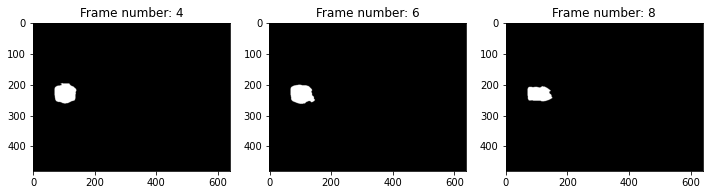

In [ ]:
test_sequence = []

video_number = random.randint(0, 14)
for frame_num in range(4,9,2):
  res = np.load(os.path.join(DATA_PATH, "firm", str(video_number), "{}.npy".format(frame_num)))
  test_sequence.append(res)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title('Frame number: 4')
plt.imshow(test_sequence[0], cmap='gray')
plt.subplot(132)
plt.title('Frame number: 6')
plt.imshow(test_sequence[1], cmap='gray')
plt.subplot(133)
plt.title('Frame number: 8')
plt.imshow(test_sequence[2], cmap='gray')


plt.show()


# Train the model


We run the training process 5 separate times to ensure that we achieve the best model. We use tensorboard to log all of our training results.

In [ ]:
# Define parameters for training
training_num = 109
bs = 16

# Create our training and validation set 
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state = 0)

# Run and train our model 5 times to ensure that we get to the best possible model 
runLSTM(trainingNum=training_num, learningRate=0.0001, batchSize=bs, version="bs_16_st_1_lr_0.0001_1", XTrain=x_train, YTrain=y_train, XVal=x_val, YVal=y_val)
runLSTM(trainingNum=training_num, learningRate=0.0001, batchSize=bs, version="bs_16_st_1_lr_0.0001_2", XTrain=x_train, YTrain=y_train, XVal=x_val, YVal=y_val)
runLSTM(trainingNum=training_num, learningRate=0.0001, batchSize=bs, version="bs_16_st_1_lr_0.0001_3", XTrain=x_train, YTrain=y_train, XVal=x_val, YVal=y_val)
runLSTM(trainingNum=training_num, learningRate=0.0001, batchSize=bs, version="bs_16_st_1_lr_0.0001_4", XTrain=x_train, YTrain=y_train, XVal=x_val, YVal=y_val)
runLSTM(trainingNum=training_num, learningRate=0.0001, batchSize=bs, version="bs_16_st_1_lr_0.0001_5", XTrain=x_train, YTrain=y_train, XVal=x_val, YVal=y_val)

# Evaluation

In the following section we load our models and evaluate them to determine our best model and also what our final results are for the project

In [ ]:
training_num = 109
model = create_model(0.0001)

training_folder_path = "training_" + str(training_num) + "/"

# ROUND 1: Load our model and run some evaluation metrics to determine its performance
test_version = "bs_8_st_1_lr_0.0001_1"
print("\n\nEVALUATION FOR: " + test_version)
checkpoint_path = training_folder_path  + test_version + "/" + "cp.ckpt"
model.load_weights("/content/drive/MyDrive/Dissertation/checkpoints/project/LSTM/" + checkpoint_path)
evaluation = model.evaluate(X_test, Y_test)
yhat = model.predict(X_test)
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print(multilabel_confusion_matrix(ytrue, yhat))
print(accuracy_score(ytrue, yhat))
print(classification_report(ytrue,yhat))

# ROUND 2: Load our model and run some evaluation metrics to determine its performance
test_version = "bs_8_st_1_lr_0.0001_2"
print("\n\nEVALUATION FOR: " + test_version)
checkpoint_path = training_folder_path  + test_version + "/" + "cp.ckpt"
model.load_weights("/content/drive/MyDrive/Dissertation/checkpoints/project/LSTM/" + checkpoint_path)
evaluation = model.evaluate(X_test, Y_test)
yhat = model.predict(X_test)
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print(multilabel_confusion_matrix(ytrue, yhat))
print(accuracy_score(ytrue, yhat))
print(classification_report(ytrue,yhat))

# ROUND 3: Load our model and run some evaluation metrics to determine its performance
test_version = "bs_8_st_1_lr_0.0001_3"
print("\n\nEVALUATION FOR: " + test_version)
checkpoint_path = training_folder_path  + test_version + "/" + "cp.ckpt"
model.load_weights("/content/drive/MyDrive/Dissertation/checkpoints/project/LSTM/" + checkpoint_path)
evaluation = model.evaluate(X_test, Y_test)
yhat = model.predict(X_test)
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print(multilabel_confusion_matrix(ytrue, yhat))
print(accuracy_score(ytrue, yhat))
print(classification_report(ytrue,yhat))

# ROUND 4: Load our model and run some evaluation metrics to determine its performance
test_version = "bs_8_st_1_lr_0.0001_4"
print("\n\nEVALUATION FOR: " + test_version)
checkpoint_path = training_folder_path  + test_version + "/" + "cp.ckpt"
model.load_weights("/content/drive/MyDrive/Dissertation/checkpoints/project/LSTM/" + checkpoint_path)
evaluation = model.evaluate(X_test, Y_test)
yhat = model.predict(X_test)
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print(multilabel_confusion_matrix(ytrue, yhat))
print(accuracy_score(ytrue, yhat))
print(classification_report(ytrue,yhat))

# ROUND 5: Load our model and run some evaluation metrics to determine its performance
test_version = "bs_8_st_1_lr_0.0001_5"
print("\n\nEVALUATION FOR: " + test_version)
checkpoint_path = training_folder_path  + test_version + "/" + "cp.ckpt"
model.load_weights("/content/drive/MyDrive/Dissertation/checkpoints/project/LSTM/" + checkpoint_path)
evaluation = model.evaluate(X_test, Y_test)
yhat = model.predict(X_test)
ytrue = np.argmax(Y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print(multilabel_confusion_matrix(ytrue, yhat))
print(accuracy_score(ytrue, yhat))
print(classification_report(ytrue,yhat))